# Log

* Written by YongGi Hong / email : yghong@medicalip.com
* Written date : 20230208

---

# Code desc

* Projection data
* Padding 
* Upsampling

---

# 1. Package Import 

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from math import ceil,floor
import os, glob, shutil
import nibabel as nib
import cv2 as cv


# 2. Utils function

In [168]:
def Load_nii (path):
    '''
    Load Nifti data

    Args :
        path : nifti data file path
    Returns :
        3D CT array

    '''
    nii = nib.load(path).get_fdata()
    return nii

def Save_nii(save_array, original_path, save_path):
    '''
    Save Nifti data

    Args :
        save_array : save nifti array
        original_path : load 했었넌 original nifti file path
        save_path : save 할 위치

    '''
    nii = nib.load(original_path)
    header = nii.header
    affine = nii.affine
    arr =  nib.Nifti1Image(save_array,affine=affine, header=header)
    nib.save(arr,save_path)

def projection(array, projection_axis = 1):
    '''
    CT 이미지에서 X-ray이미지로 변환하기 위한 함수
    Coronal 방향으로 projection하여 2D medical image로 변환함


    Args :
        array : 3D CT array
        projection_axis : 0 is Segittal plane, 1 is Coronal plane, 2 is Transverse plane

    Returns :
        array : 2D CT array

    '''
    array = np.mean(array ,axis=projection_axis )

    return array

def padding(array,size):
    '''
    :param array: 2D projection CT array
    :param size: padding after resize shape
    :return: padding resize 2D CT array
    '''

    width, height = array.shape[0],array.shape[1]

    # 가로가 세로보다 길 경우 세로에 padding을 해주어야 한다.
    # -1024로 패딩 진행
    if width > height :
        pad_size = width
        h_start_idx  = int((width-height)/2)
        h_end_idx    = h_start_idx + height
        w_start_idx  = 0
        w_end_idx    = width

    elif height > width :
        pad_size = height
        w_start_idx  = int((height-width)/2)
        w_end_idx    = w_start_idx + width
        h_start_idx  = 0
        h_end_idx    = height
    else : # 같을 경우
        pad_size = height
        w_start_idx  = 0
        h_start_idx  = 0
        w_end_idx    = width
        h_end_idx    = height

    pad_array = np.zeros((pad_size,pad_size))
    pad_array = pad_array + array.min()
    pad_array[w_start_idx:w_end_idx,h_start_idx:h_end_idx] = array

    resize_pad_array = cv.resize( (pad_array), (size, size),interpolation=cv.INTER_LINEAR )
    return resize_pad_array

In [169]:
CT_paths = glob.glob('./data/3D_CT/*.nii.gz')
Bone_paths = glob.glob('./data/3D_Bone/*.nii.gz')
Skin_paths = glob.glob('./data/3D_Skin/*.nii.gz')
Muscle_paths = glob.glob('./data/3D_Muscle/*.nii.gz')
AVF_paths = glob.glob('./data/3D_AVF/*.nii.gz')
OF_paths = glob.glob('./data/3D_OF(SF)/*.nii.gz')
IO_paths = glob.glob('./data/3D_IO/*.nii.gz')
BSC_paths = glob.glob('./data/3D_BSC(CNS)/*.nii.gz')
whole_body_paths = glob.glob('./data/3D_whole_body/*.nii.gz')
Mask_paths = glob.glob('./data/3D_Mask/*.nii.gz')

In [170]:
def convert (path_list,size = 2048):
    for path in path_list:
        nii = Load_nii(path)
        nii = projection(nii)
        nii = padding(nii,size)
        save_path = path.replace('3D','2D')
        dir_path = os.path.dirname(save_path)
        try:
            os.makedirs(dir_path)
        except:
            pass
        Save_nii(nii,path,save_path)
        # return nii


In [171]:
convert(CT_paths)
convert(Bone_paths)
convert(Skin_paths)
convert(Muscle_paths)
convert(AVF_paths)
convert(OF_paths)
convert(IO_paths)
convert(BSC_paths)
convert(whole_body_paths)
convert(Mask_paths)


# 3. Check

In [104]:
masks_name = ['Skin', 'Bone', 'Muscle','AVF','OF(SF)','IO', 'BSC(CNS)']

In [ ]:
merge = np.zeros((2048,2048))

for i in range(len(masks_name)):
    mask_3d = Load_nii('./data/3D_{}/12204634_INSPI.nii.gz'.format(masks_name[i]))* (i+1)
    print(np.unique(mask_3d))
    mask_2d = projection(mask_3d,1)
    mask_2d = padding(mask_2d,2048)
    merge = merge + mask_2d
merge = np.fliplr(np.rot90(merge,3))

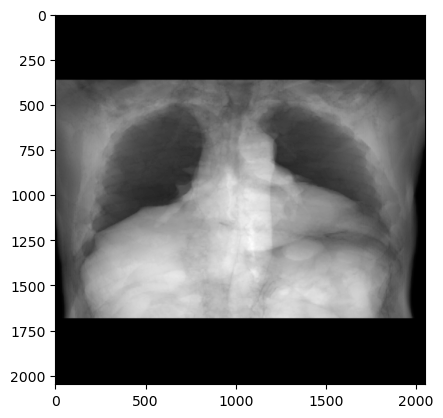

In [125]:
plt.imshow(merge, cmap='gray')

In [155]:
whole_3d = np.array(Load_nii(Mask_paths[0]),dtype=np.int8)
whole2d_data = projection(whole_3d,1)
whole_xray = np.fliplr(np.rot90( padding(whole2d_data,2048),3))


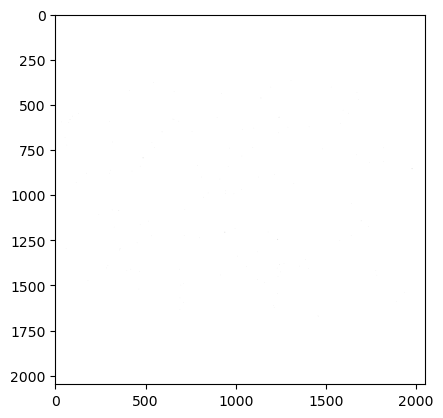

In [159]:
plt.imshow(np.round(merge,2) - np.round(whole_xray,2),cmap='gray')

In [160]:
diff = np.round(whole_xray,2)-np.round( merge,2)

In [166]:
np.unique(diff)

array([0.  , 0.01, 0.01])